In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch import optim
from torchvision import transforms as T
from torchvision.utils import make_grid
from tqdm import tqdm 
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import time

In [2]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

# Lenet Model

In [3]:
class LeNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [4]:
# get device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# Qut Fish Dataset

In [5]:
# get all classes for the dataset
classes = []
classes_file = r"C:\Users\hansm\Github\CIS472-CourseProject\Project Datasets\Dataset1\QutFishDataset\archive\Fish_data\final_all_index.txt"
with open(classes_file) as classesf:
    for line in classesf:
        splitted_line = line.strip().split('=')
        cls = splitted_line[1]
        if cls not in classes:
            classes.append(cls)
        else:
            continue
    classesf.close()
print(len(classes))

483


In [6]:
class QutFishDataset(Dataset):
    def __init__(self, data_path, transform=None):
        self.data_path = data_path
        self.transform = transform
        self.labels = []
        self.images = []
        
        index_file = f"{self.data_path}\\final_all_index.txt"
        with open(index_file) as indexf:
            for line in indexf:
                splitted_line = line.strip().split('=')
                label = splitted_line[0]
                image = splitted_line[4] + ".png"
                self.labels.append(label)
                self.images.append(image)
            indexf.close()
        
    def __len__(self):
        return len(self.images)
        
    def __getitem__(self, idx):
        img = Image.open(f"{self.data_path}\\images\\numbered\\{self.images[idx]}").convert('RGB')
        img = self.transform(img)
        label = torch.tensor(int(self.labels[idx]) - 1)
        return img, label

**Lenet Training for QUT Fish Dataset**

In [7]:
lenet = LeNet(483)
lenetModel = lenet.to(device)
print(lenetModel)

LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=483, bias=True)
)


In [8]:
# hyperparameters
batch_size = 35
learning_rate=0.001
nepochs = 4

In [18]:
# transform
transform = T.Compose([
    T.Resize((32, 32)),
    T.ToTensor(),
])

In [19]:
# Split dataset into train and test sets
data_path = "C:\\Users\\hansm\\Github\\CIS472-CourseProject\\Project Datasets\\Dataset1\\QutFishDataset\\archive\\Fish_data"
fish_data = QutFishDataset(data_path=data_path, transform=transform)
train_size = int(0.8 * len(fish_data))
test_size = len(fish_data) - train_size
train_dataset, test_dataset = random_split(fish_data, [train_size, test_size])

In [20]:
# train and test loader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print(len(train_loader))

101


Type: <class 'list'>
Length: 2
More Types: <class 'torch.Tensor'>, <class 'torch.Tensor'>
Shapes: torch.Size([35, 3, 32, 32]), torch.Size([35])
Labels: tensor([280,  65, 267, 343, 107, 279, 394, 382, 269, 381, 156,  58, 102, 250,
        250, 256,  77, 125, 378, 466,  17, 298, 227,  17, 384, 327,  95,  28,
        430, 344, 249, 246, 262,  60, 393])



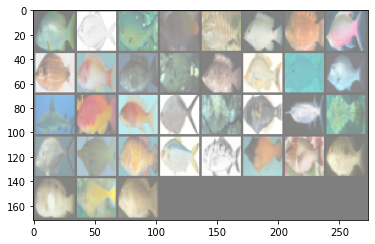

In [21]:
data = iter(train_loader) # iterate through data
single_point = next(data)
print(f"""Type: {type(single_point)}
Length: {len(single_point)}
More Types: {type(single_point[0])}, {type(single_point[1])}
Shapes: {single_point[0].shape}, {single_point[1].shape}
Labels: {single_point[1]}
""")
img_grid = make_grid(single_point[0])
matplotlib_imshow(img_grid)

In [22]:
# Adam optimizer
optimizer = optim.Adam(lenetModel.parameters(), lr=learning_rate)

# loss function
LossFunction = nn.CrossEntropyLoss()

for epoch in range(nepochs):
    running_loss = 0.0
    start_time = time.time()
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        
        output = lenetModel(inputs)
        loss = LossFunction(output, labels)
        loss.backward()
        optimizer.step()
        
        end_time = time.time()
        elapsed_time = (end_time - start_time)/60
        running_loss += loss.item()
        if (i+1) % 10 == 0:
            print('[epoch: %d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 10))
            print(f"Time: {elapsed_time} min")
            running_loss = 0.0
    print()

print("Lenet Finished Training for QUT Fish Dataset")

[epoch: 1,    10] loss: 6.173
Time: 0.14581908782323202 min
[epoch: 1,    20] loss: 6.179
Time: 0.272417946656545 min
[epoch: 1,    30] loss: 6.177
Time: 0.40706173578898114 min
[epoch: 1,    40] loss: 6.181
Time: 0.5430088758468627 min
[epoch: 1,    50] loss: 6.171
Time: 0.6818100730578105 min
[epoch: 1,    60] loss: 6.155
Time: 0.8198627710342408 min
[epoch: 1,    70] loss: 6.142
Time: 0.9380568385124206 min
[epoch: 1,    80] loss: 6.147
Time: 1.0774574398994445 min
[epoch: 1,    90] loss: 6.164
Time: 1.2049920161565144 min
[epoch: 1,   100] loss: 6.123
Time: 1.3343539913495381 min

[epoch: 2,    10] loss: 6.040
Time: 0.025531578063964843 min
[epoch: 2,    20] loss: 6.062
Time: 0.05122868220011393 min
[epoch: 2,    30] loss: 6.055
Time: 0.07584294080734252 min
[epoch: 2,    40] loss: 6.062
Time: 0.1013949155807495 min
[epoch: 2,    50] loss: 6.039
Time: 0.13347940444946288 min
[epoch: 2,    60] loss: 6.116
Time: 0.16680338780085247 min
[epoch: 2,    70] loss: 6.065
Time: 0.1917797724

In [24]:
accuracy = 0
total = 0

with torch.no_grad():
    lenetModel.eval()
    for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        output = lenetModel(inputs)
        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        accuracy += (predicted == labels).sum().item()

print(f"Total accuracy for leNet for QUT Fish Dataset = {100 * accuracy / total:.2f}%")

Total accuracy for leNet for QUT Fish Dataset = 1.36%
